# Predicting Area of Forest Fires

This Notebook was built to select the best model to use in predicting the area a forest fire in california will consume using different data available to us to build the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
fires = pd.read_csv('fires.csv')

In [3]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [4]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [5]:
fires.isnull().sum()

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

In [6]:
fires.describe(include='all')

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517,517,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
unique,NaN,NaN,NaN,12,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,aug,sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,184,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,259.000000,4.669246,4.299807,NaN,NaN,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,149.389312,2.313778,1.229900,NaN,NaN,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,1.000000,2.000000,NaN,NaN,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,130.000000,3.000000,4.000000,NaN,NaN,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,259.000000,4.000000,4.000000,NaN,NaN,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,388.000000,7.000000,5.000000,NaN,NaN,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000


## Data Processing

First, we'll convert the month column into a categorical feature. Instead of using the strings, we'll convert it into an indicator for the summer months in the northern hemisphere.

For the sake of completion, we'll impute all of the features so that we can have the biggest set to choose from for sequential feature selection. We'll go with K-nearest neighbors imputation since we expect area damage to be similar among similar fires.

##### area

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

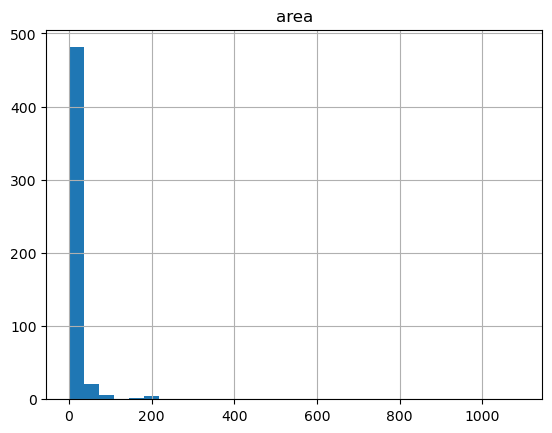

In [7]:
fires.hist("area", bins=30)

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

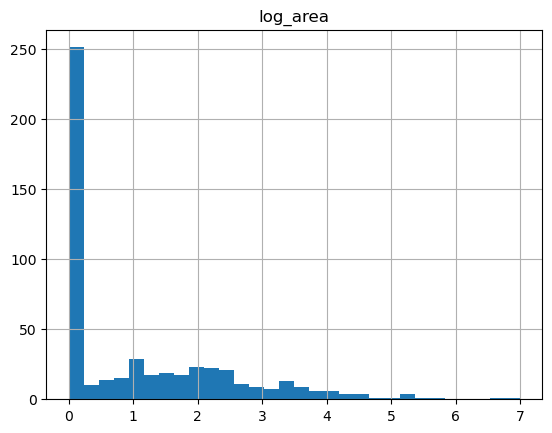

In [8]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

##### month

Instead of using month directly, we'll derive another feature called summer that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely

In [9]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = [is_summer_month(m) for m in fires["month"]]

In [10]:
fires

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,summer
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.00,0.000000,0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.00,0.000000,0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.00,0.000000,0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.00,0.000000,0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.00,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,513,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0,6.44,2.006871,1
513,514,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0,54.29,4.012592,1
514,515,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,11.16,2.498152,1
515,516,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0,0.00,0.000000,1


Deal with missing values using knninmputer

In [11]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


### Visualizations

<AxesSubplot:>

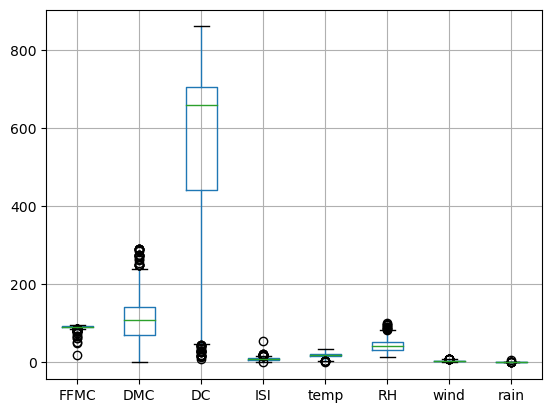

In [12]:
imputed.boxplot()

From the boxplot it appears there are outliers, lets check for them

In [13]:
for col in imputed:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


comparing our columns against log_area, we will first scale them

#### FFMC vs log_area

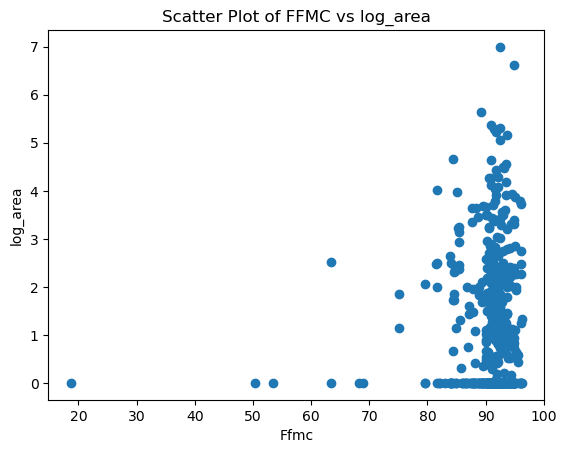

In [14]:
x_values = imputed['FFMC']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('Ffmc')
plt.ylabel('log_area')
plt.title('Scatter Plot of FFMC vs log_area')

plt.show()

The scatterplot shows that there is a concentration of the data on the right, suggesting a kind of relationship

#### DMC vs log_area

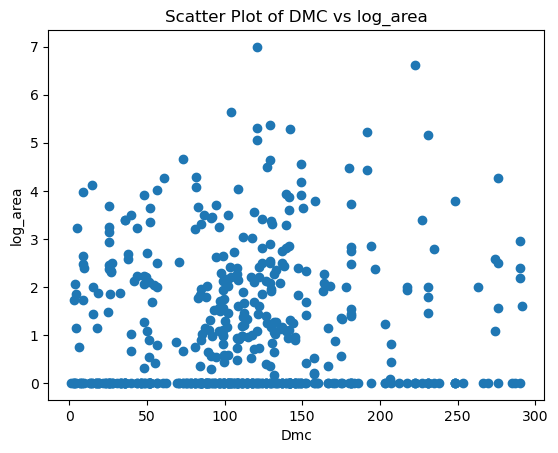

In [15]:
x_values = imputed['DMC']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('Dmc')
plt.ylabel('log_area')
plt.title('Scatter Plot of DMC vs log_area')

plt.show()

The scatterplot suggests their is no relationship between DMC and log_area

#### DC vs log_area

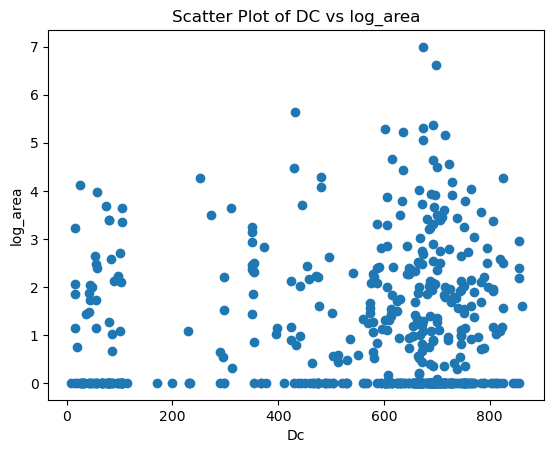

In [16]:
x_values = imputed['DC']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('Dc')
plt.ylabel('log_area')
plt.title('Scatter Plot of DC vs log_area')

plt.show()

The scatterplot suggests there is no relationship between DC and log_area

#### ISI vs log_area

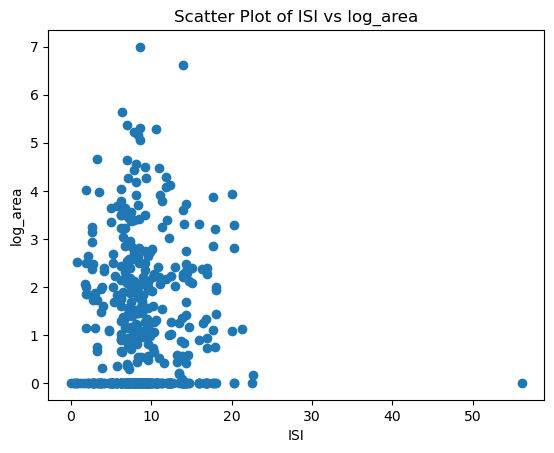

In [17]:
x_values = imputed['ISI']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('ISI')
plt.ylabel('log_area')
plt.title('Scatter Plot of ISI vs log_area')

plt.show()

The scatterplot shows there is no relationship between them

#### temp vs log_area

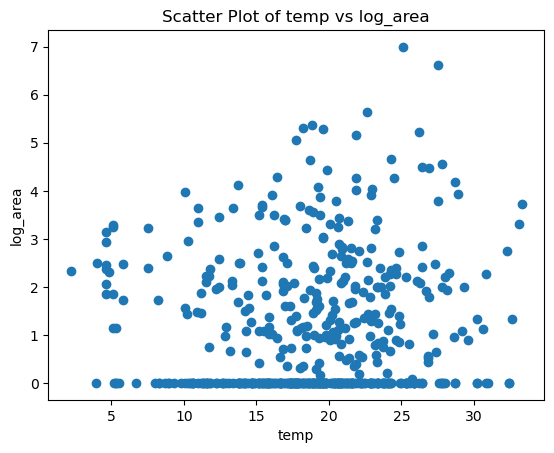

In [18]:
x_values = imputed['temp']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('temp')
plt.ylabel('log_area')
plt.title('Scatter Plot of temp vs log_area')

plt.show()

The scatterplot doesnt show a relationship between them

#### RH vs log_area

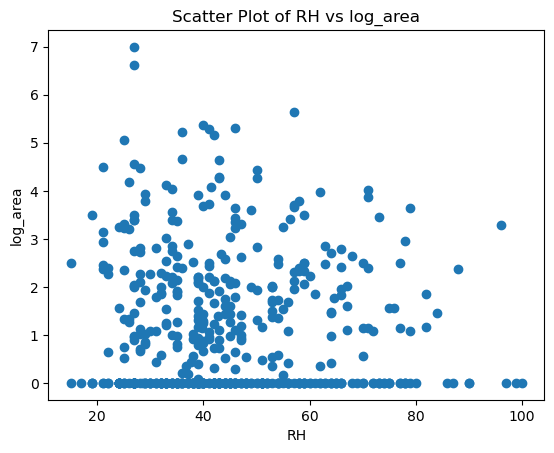

In [19]:
x_values = imputed['RH']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('RH')
plt.ylabel('log_area')
plt.title('Scatter Plot of RH vs log_area')

plt.show()

The scatterplot does not show a relationship between them

#### Wind vs log_area

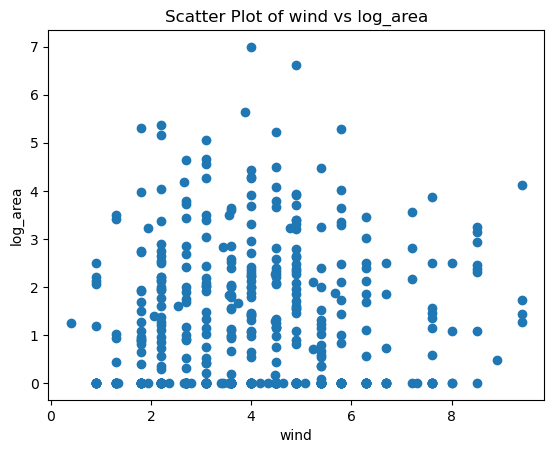

In [20]:
x_values = imputed['wind']
y_values = fires['log_area']

# Create a scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('wind')
plt.ylabel('log_area')
plt.title('Scatter Plot of wind vs log_area')

plt.show()

This also doesnt show any relationship

Since we are not able to see relationships, we will use other methods in selecting features

we will scale the data next

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

final = pd.concat([fires[["summer", "log_area"]], scaled], axis=1)
final

,summer,log_area,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,0.000000,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,0.000000,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,0.000000,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.000000,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,0.000000,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...,...
512,1,2.006871,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,4.012592,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,2.498152,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.000000,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


## Feature selection

we will use Sequentialfeatureselector for both front and back to select the best features

In [22]:
from sklearn.feature_selection import SequentialFeatureSelector

final = final.drop('log_area', axis=1)

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [23]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


Based on the features chosen by forward and backward selection, it seems like DC, wind and FFMC seem to be the most impactful on predicting log_area

In [24]:
fw2_model = LinearRegression() # .fit(final[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(final[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(final[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(final[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(final[backward6.get_feature_names_out()], y)

### More Candidate Models

Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model.

In [25]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  1372.2342342342342
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.

In [26]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  1371.3713713713714


### K-Fold Cross-Validation

In [27]:
from sklearn.model_selection import cross_val_score 
reference = LinearRegression()

reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")

In [28]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(ridge_cv), " SD: ", np.std(ridge_cv))

Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697586
Forward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Forward-6 Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343
Backward-2 Model, Avg Test MSE:  -2.173357302739327  SD:  1.0038109503795958
Backward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Backward-6 Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343
Ridge Model, Avg Test MSE:  -2.196754531261845  SD:  1.0390316623530433


Among our candidate models, the forward and backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.